In [1]:
# Imports
from clef.code import *
import statistics
# Imports
import datetime
import sys
import os
from importlib import reload
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import xarray as xr
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import xesmf as xe

In [2]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
def tas_weighed(tas):
    """Compute lat weighed annual temperature progression
    
    Inputs:
    tas: temperature array from dataset (time,lat,lon)
    
    Outputs:
    tas_weighed_mean: 1D Temp array (time)
    
    """
    # Weighing Data
    weights = np.cos(np.deg2rad(tas.lat))
    weights.name = "weights"

    tas_weighed = tas.weighted(weights) # latitude weighted temperature array
    

    tas_weighed_mean = tas_weighed.mean(("lon", "lat")) # average surface air temperature weighed (over time)
    
    return tas_weighed_mean

In [4]:
def slice_and_merge_full_run(ds_1pctCO2, ds_ZEC):
    """Goal is to slice 1pctCO2 run at the branching point, and merge the sliced data with the branching
    phase of the full zecmip experiment.
    
    Arguments:
    
    ds_1pctCO2 (data array): time, lat, lon 1pctCO2 data array
    ds_ZEC (data array): time, lat, lon ZEC phase data array
    time_1pctCO2_branch (time): time associated with branching point 1pctCO2 -> ZEC phase
    
    
    Return:
    
    
    """
    # Slicing the 1pctCO2 data array
    date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch = find_date_branch(ds_ZEC, ds_1pctCO2)
    
    # getting year of branch -- this is assuming a years resample for plotting
    year_branch = round(time_1pctCO2_branch_index/12)
    
    ds_1pctCO2_sliced = ds_1pctCO2.sel(time=slice(ds_1pctCO2.time[0], time_1pctCO2_branch))
    
    #Concatenate with the ZEC phase of the experiment
    ds_sliced_concatenated = xr.concat([ds_1pctCO2_sliced, ds_ZEC], dim="time")
        
    return ds_sliced_concatenated, year_branch

In [5]:
def find_date_branch(ds_ZEC, ds_1pctCO2):
    """Goal is to find the date and index of date of branch in the 1pctCO2 run
    
    Arguments:
    
    ds_ZEC (data array): ZEC phase data array for ZECMIP run
    ds_1pctCO2 (data array): 1pctCO2 phase data array for ZECMIP run
    
    Returns:
    
    time_1pctCO2_branch_index (int): Index for the exact month+year of branching point
    date_initial_ZEC (date): first date from the ZEC phase of the experiment
    time_1pctCO2_branch (date): Date of branch (should match EXACT date_initial_ZEC)
    
    """
    
    # Figure out the first date of the ZEC branch
    date_initial_ZEC = ds_ZEC.time[0]
    
    for i in range(len(ds_1pctCO2.time)):
        
        # Pick time value
        time_1pctCO2 = ds_1pctCO2.time[i]
        
        # Checking if time in 1pctCO2 is same as initial ZEC
        if time_1pctCO2 == date_initial_ZEC:
            
            # if the dates are equal on branch and 1pctCO2, this is the branching date
            time_1pctCO2_branch_index = i
            
            # assign time
            time_1pctCO2_branch=ds_1pctCO2.time[i]
        
    return date_initial_ZEC, time_1pctCO2_branch_index, time_1pctCO2_branch


# Static variables for use

In [6]:
model_names = ["MIROC-ES2L", "UKESM1-0-LL",
              "ACCESS-ESM1.5"]

model_name_str = model_names

# Importing ungridded monthly piControl data

In [7]:
ACCESS_pr_piControl_ungridded = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/pr/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

MIROC_pr_piControl_ungridded = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/pr/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

MOHC_pr_piControl_ungridded = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/pr/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

In [8]:
ACCESS_tas_piControl_ungridded = xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/latest/*.nc',
                                     combine='nested',concat_dim='time')

MIROC_tas_piControl_ungridded = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc',
                                     combine='nested',concat_dim='time')

MOHC_tas_piControl_ungridded = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc',
                                     combine='nested',concat_dim='time')

#### piControl pr data regridded for plotting

In [9]:
ds_ACCESS_piControl_pr = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_piControl/ds_piControl_ACCCESS_gridded.nc')
ds_MIROC_piControl_pr = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_piControl/ds_piControl_MIROC_gridded_v2.nc')
ds_MOHC_piControl_pr = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_piControl/ds_piControl_MOHC_gridded.nc')

In [10]:
concat_piControl_pr = [ds_MIROC_piControl_pr, ds_MOHC_piControl_pr, ds_ACCESS_piControl_pr]

In [11]:
MOHC_piControl_tas = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/pre_industrial_control/MOHC_piControl_regridded.nc')
ACCESS_piControl_tas = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/pre_industrial_control/ACCESS_piControl_regridded.nc')
MIROC_piControl_tas = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/pre_industrial_control/MIROC_piControl_regridded.nc')


In [12]:
concat_piControl_tas_regridded = [MOHC_piControl_tas, MOHC_piControl_tas,
                       ACCESS_piControl_tas]

# Continuing import of 1pctCO2 and branches -- monthly data

### pr monthly 1pctCO2 and ZEC data

In [13]:
# Regridded
ds_ACCESS_1pctCO2_pr = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_1pctCO2/ACCESS_1pctCO2_regridded.nc')
ds_MIROC_1pctCO2_pr = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_1pctCO2/MIROC_1pctCO2_regridded.nc')
ds_MOHC_1pctCO2_pr = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_1pctCO2/MOHC_1pctCO2_regridded.nc')


In [14]:
concat_1pctCO2_pr = [ds_MIROC_1pctCO2_pr, ds_MOHC_1pctCO2_pr,
                      ds_ACCESS_1pctCO2_pr]

In [15]:
ds_ACCESS_ZEC_pr_1000PgC = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/ACCESS_pr_ZEC_regridded.nc')
ds_MIROC_ZEC_pr_1000PgC = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/MIROC_pr_ZEC_regridded.nc')
ds_MOHC_ZEC_pr_1000PgC = xr.open_dataset('/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/MOHC_pr_ZEC_regridded.nc')

In [16]:
ds_ACCESS_ZEC_pr_750PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/750_PgC/ACCESS_pr_750_regridded.nc")
ds_MIROC_ZEC_pr_750PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/750_PgC/MIROC_pr_750_regridded.nc")
ds_MOHC_ZEC_pr_750PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/750_PgC/MOHC_pr_750_regridded.nc")

In [17]:
ds_ACCESS_ZEC_pr_2000PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/2000_PgC/ACCESS_pr_2000_regridded.nc")
ds_MOHC_ZEC_pr_2000PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/2000_PgC/MOHC_pr_2000_regridded.nc")
ds_MIROC_ZEC_pr_2000PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/2000_PgC/MIROC_pr_2000_regridded.nc")
ds_CCCma_ZEC_pr_2000PgC  = xr.open_dataset("/g/data/ob22/lc6551/ZEC_pr/pr_regridded_ZEC/2000_PgC/CCCma_pr_2000_regridded.nc")

In [18]:
concat_ZEC_pr_1000PgC = [ds_MIROC_ZEC_pr_1000PgC, ds_MOHC_ZEC_pr_1000PgC,
                      ds_ACCESS_ZEC_pr_1000PgC]


In [19]:
concat_ZEC_pr_750PgC = [ds_MIROC_ZEC_pr_750PgC, ds_MOHC_ZEC_pr_750PgC, 
                        ds_ACCESS_ZEC_pr_750PgC]

In [20]:
concat_ZEC_pr_2000PgC = [ds_MIROC_ZEC_pr_2000PgC, ds_MOHC_ZEC_pr_2000PgC, 
                        ds_ACCESS_ZEC_pr_2000PgC]

### tas monthly 1pctCO2 and ZEC data

In [21]:
ds_ZEC_MIROC_tas_1000PgC = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/ZEC_1000PgC/MIROC_tas_ZEC_regridded.nc')
ds_ZEC_MOHC_tas_1000PgC = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/ZEC_1000PgC/MOHC_tas_ZEC_regridded.nc')
ds_ZEC_ACCESS_tas_1000PgC = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/ZEC_1000PgC/ACCESS_tas_ZEC_regridded.nc')

In [22]:
concat_ZEC_tas_1000PgC = [ds_ZEC_MIROC_tas_1000PgC, ds_ZEC_MOHC_tas_1000PgC,
                      ds_ZEC_ACCESS_tas_1000PgC]

In [23]:
ds_1pctCO2_MIROC_tas = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/1pctCO2/MIROC_tas_1pctCO2_regridded.nc') # bad
ds_1pctCO2_MOHC_tas = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/1pctCO2/MOHC_tas_1pctCO2_regridded.nc')
ds_1pctCO2_ACCESS_tas = xr.open_dataset('/g/data/ob22/lc6551/ZEC/updated_2_degree_regrids/1pctCO2/ACCESS_tas_1pctCO2_regridded.nc')


In [24]:
# 2000PgC branches
ds_ZEC_MIROC_tas_2000PgC=xr.open_dataset("/g/data/ob22/lc6551/Multiple_branch_analysis/MIROC/MIROC_ZEC_2000PgC_regridded.nc")
ds_ZEC_ACCESS_tas_2000PgC=xr.open_dataset("/g/data/ob22/lc6551/Multiple_branch_analysis/ACCESS/ACCESS_2000PgC_mon_regridded.nc")
ds_ZEC_MOHC_tas_2000PgC=xr.open_dataset("/g/data/ob22/lc6551/Multiple_branch_analysis/MOHC/MOHC_2000PgC_mon_regridded.nc")

In [25]:
concat_ZEC_tas_2000PgC = [ds_ZEC_MIROC_tas_2000PgC, ds_ZEC_MOHC_tas_2000PgC,
                      ds_ZEC_ACCESS_tas_2000PgC]

In [26]:
# 750PgC branches
ds_ZEC_MIROC_tas_750PgC=xr.open_dataset("/g/data/ob22/lc6551/Multiple_branch_analysis/MIROC/MIROC_ZEC_750PgC_regridded.nc")
ds_ZEC_ACCESS_tas_750PgC=xr.open_dataset("/g/data/ob22/lc6551/Multiple_branch_analysis/ACCESS/ACCESS_750PgC_mon_regridded.nc")
ds_ZEC_MOHC_tas_750PgC=xr.open_dataset("/g/data/ob22/lc6551/Multiple_branch_analysis/MOHC/MOHC_750PgC_mon_regridded.nc")

In [27]:
concat_ZEC_tas_750PgC = [ds_ZEC_MIROC_tas_750PgC, ds_ZEC_MOHC_tas_750PgC,
                      ds_ZEC_ACCESS_tas_750PgC]

# slicing and concatenating full monthly for time series

In [28]:
# 1000 PgC --> tas
[MIROC_tas_concatenated_1000PgC_tas,
 time_MIROC_1000PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_MIROC_tas, ds_ZEC_MIROC_tas_1000PgC)

[MOHC_tas_concatenated_1000PgC_tas,
 time_MOHC_1000PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_MOHC_tas, ds_ZEC_MOHC_tas_1000PgC)

[ACCESS_tas_concatenated_1000PgC_tas,
 time_ACCESS_1000PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_ACCESS_tas, ds_ZEC_ACCESS_tas_1000PgC)


In [29]:
concat_1000PgC_full_tas = [MIROC_tas_concatenated_1000PgC_tas, MOHC_tas_concatenated_1000PgC_tas,
                          ACCESS_tas_concatenated_1000PgC_tas]

In [30]:
# 750 PgC --> concatenating tas
[MIROC_tas_concatenated_750PgC_tas,
 time_MIROC_750PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_MIROC_tas, ds_ZEC_MIROC_tas_750PgC)

[MOHC_tas_concatenated_750PgC_tas,
 time_MOHC_750PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_MOHC_tas, ds_ZEC_MOHC_tas_750PgC)

[ACCESS_tas_concatenated_750PgC_tas,
 time_ACCESS_750PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_ACCESS_tas, ds_ZEC_ACCESS_tas_750PgC)


In [31]:
concat_750PgC_full_tas = [MIROC_tas_concatenated_750PgC_tas, MOHC_tas_concatenated_750PgC_tas,
                          ACCESS_tas_concatenated_750PgC_tas]

In [32]:
# 2000 PgC --> tas
[MIROC_tas_concatenated_2000PgC_tas,
 time_MIROC_2000PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_MIROC_tas, ds_ZEC_MIROC_tas_2000PgC)

[MOHC_tas_concatenated_2000PgC_tas,
 time_MOHC_2000PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_MOHC_tas, ds_ZEC_MOHC_tas_2000PgC)

[ACCESS_tas_concatenated_2000PgC_tas,
 time_ACCESS_2000PgC_tas]=slice_and_merge_full_run(ds_1pctCO2_ACCESS_tas, ds_ZEC_ACCESS_tas_2000PgC)


In [33]:
concat_2000PgC_full_tas = [MIROC_tas_concatenated_2000PgC_tas, MOHC_tas_concatenated_2000PgC_tas,
                          ACCESS_tas_concatenated_2000PgC_tas]

# slicing and concatenating precipitation data - monthly pr

In [34]:
[MIROC_pr_concatenated_750PgC,
 time_MIROC_750PgC]=slice_and_merge_full_run(ds_MIROC_1pctCO2_pr, ds_MIROC_ZEC_pr_750PgC)

[MOHC_pr_concatenated_750PgC,
 time_MOHC_750PgC]=slice_and_merge_full_run(ds_MOHC_1pctCO2_pr, ds_MOHC_ZEC_pr_750PgC)

[ACCESS_pr_concatenated_750PgC,
 time_ACCESS_750PgC]=slice_and_merge_full_run(ds_ACCESS_1pctCO2_pr, ds_ACCESS_ZEC_pr_750PgC)

concat_750PgC_full_pr = [MIROC_pr_concatenated_750PgC, 
                        MOHC_pr_concatenated_750PgC,
                        ACCESS_pr_concatenated_750PgC]

time_slice_concat_750PgC = [time_MIROC_750PgC,
                            time_MOHC_750PgC,
                            time_ACCESS_750PgC]

In [35]:
[MIROC_pr_concatenated_1000PgC,
 time_MIROC_1000PgC]=slice_and_merge_full_run(ds_MIROC_1pctCO2_pr, ds_MIROC_ZEC_pr_1000PgC)

[MOHC_pr_concatenated_1000PgC,
 time_MOHC_1000PgC]=slice_and_merge_full_run(ds_MOHC_1pctCO2_pr, ds_MOHC_ZEC_pr_1000PgC)

[ACCESS_pr_concatenated_1000PgC,
 time_ACCESS_1000PgC]=slice_and_merge_full_run(ds_ACCESS_1pctCO2_pr, ds_ACCESS_ZEC_pr_1000PgC)

concat_1000PgC_full_pr = [MIROC_pr_concatenated_1000PgC, MOHC_pr_concatenated_1000PgC,
                          ACCESS_pr_concatenated_1000PgC]


time_slice_concat_1000PgC = [time_MIROC_1000PgC,
                         time_MOHC_1000PgC,
                         time_ACCESS_1000PgC]

In [36]:
[MIROC_pr_concatenated_2000PgC,
 time_MIROC_2000PgC]=slice_and_merge_full_run(ds_MIROC_1pctCO2_pr, ds_MIROC_ZEC_pr_2000PgC)

[MOHC_pr_concatenated_2000PgC,
 time_MOHC_2000PgC]=slice_and_merge_full_run(ds_MOHC_1pctCO2_pr, ds_MOHC_ZEC_pr_2000PgC)

[ACCESS_pr_concatenated_2000PgC,
 time_ACCESS_2000PgC]=slice_and_merge_full_run(ds_ACCESS_1pctCO2_pr, ds_ACCESS_ZEC_pr_2000PgC)

concat_2000PgC_full_pr = [MIROC_pr_concatenated_2000PgC, 
                        MOHC_pr_concatenated_2000PgC,
                        ACCESS_pr_concatenated_2000PgC]


time_slice_concat_2000PgC = [time_MIROC_2000PgC,
                            time_MOHC_2000PgC,
                            time_ACCESS_2000PgC]

# plotting concatenated time series

In [37]:
def variable_lat_weighed(variable):
    """
    Compute lat variable from lat,lon and maybe time data
    """
    # Weighing Data
    weights = np.cos(np.deg2rad(variable.lat))
    weights.name = "weights"

    variable_weighed = variable.weighted(weights) # latitude weighted
    

    variable_weighed_mean = variable_weighed.mean(("lon", "lat")) # average surface air temperature weighed (over time)
    
    return variable_weighed_mean

In [38]:
def GMST_anom_single_plot_rolling(concat_750PgC_full_time,
                                            concat_1000PgC_full_time,
                                            concat_2000PgC_full_time,
                                                
                                            concat_branching_time_750,
                                            concat_branching_time_1000,
                                            concat_branching_time_2000):

    """

    Creating a single plot of GMST anomaly time series instead with rolling means

    """
    nrows = 1 # would need to tack on another one for piControl
    ncols = 1 # mean and spread
    
    # mean limits
    color_str = ['g','r','b']
    color_str_scatter = ['black','black','black', 'black',
                        'black','black','black']

    linestyles = ["solid", "dotted", "dashed"]
    time_periods = 20 # 20-y rolling mean
    
    
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(8,8))

    # 750 PgC
    for model in range(len(concat_750PgC_full_time)):

        resample = variable_lat_weighed(concat_750PgC_full_time[model].resample(time="Y").mean(dim="time"))
        resample_anom = resample-resample.isel(time=0)
        rolling = resample_anom.rolling(time=time_periods, center=False, min_periods=3).mean()

        length_time = len(rolling.time)
        time_array = np.linspace(0, length_time, length_time)
        linestyle=linestyles[0]
        plt.plot(time_array, rolling.tas, color=color_str[model], label=model_name_str[model]+ " 750PgC", linestyle=linestyle)

        plt.scatter(concat_branching_time_750[model]+10, rolling.isel(time=concat_branching_time_750[model]+10).tas, color="black",
                       zorder=10)

    # 1000 PgC
    for model in range(len(concat_1000PgC_full_time)):

        resample = variable_lat_weighed(concat_1000PgC_full_time[model].resample(time="Y").mean(dim="time"))
        resample_anom = resample-resample.isel(time=0)
        rolling = resample_anom.rolling(time=time_periods, center=False, min_periods=3).mean()

        length_time = len(rolling.time)
        time_array = np.linspace(0, length_time, length_time)
        linestyle=linestyles[1]
        plt.plot(time_array, rolling.tas, color=color_str[model], label=model_name_str[model]+ " 1000PgC", linestyle=linestyle)

        plt.scatter(concat_branching_time_1000[model]+10, rolling.isel(time=concat_branching_time_1000[model]+10).tas, color="black",
                       zorder=10)
    
    # 2000 PgC
    for model in range(len(concat_2000PgC_full_time)):

        resample = variable_lat_weighed(concat_2000PgC_full_time[model].resample(time="Y").mean(dim="time"))
        resample_anom = resample-resample.isel(time=0)
        rolling = resample_anom.rolling(time=time_periods, center=False, min_periods=3).mean()

        length_time = len(rolling.time)
        time_array = np.linspace(0, length_time, length_time)
        linestyle=linestyles[2]
        plt.plot(time_array, rolling.tas, color=color_str[model], label=model_name_str[model]+ " 2000PgC", linestyle=linestyle)

        plt.scatter(concat_branching_time_2000[model]+10, rolling.isel(time=concat_branching_time_2000[model]+10).tas, color="black",
                       zorder=10)

    plt.ylim([0, 6])
    plt.xlim([0, 400])

    plt.legend()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

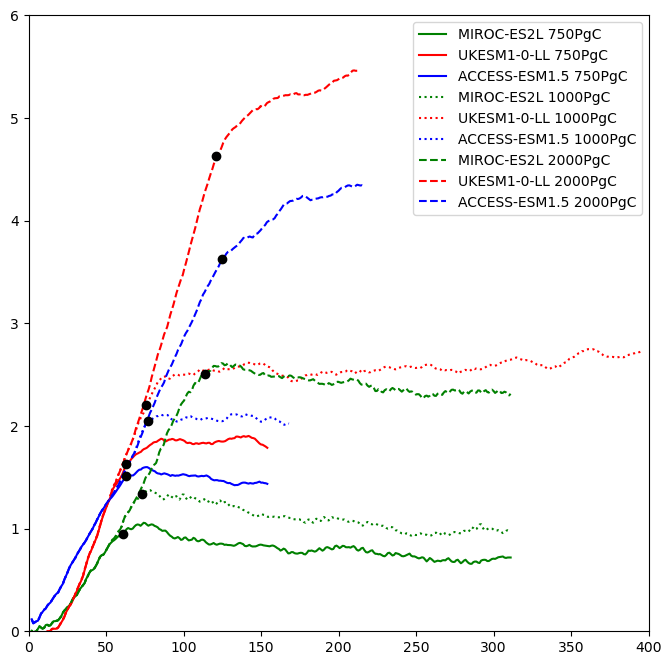

In [39]:
GMST_anom_single_plot_rolling(concat_750PgC_full_tas,
                                            concat_1000PgC_full_tas,
                                            concat_2000PgC_full_tas,
                                                
                                            time_slice_concat_750PgC,
                                            time_slice_concat_1000PgC,
                                            time_slice_concat_2000PgC)

In [40]:
def global_pr_anom_single_plot_rolling(concat_750PgC_full_time,
                                            concat_1000PgC_full_time,
                                            concat_2000PgC_full_time,
                                                
                                            concat_branching_time_750,
                                            concat_branching_time_1000,
                                            concat_branching_time_2000):

    """

    Creating a single plot of GMST anomaly time series instead with rolling means

    """
    nrows = 1 # would need to tack on another one for piControl
    ncols = 1 # mean and spread
    
    color_str = ['g','r','b']
    color_str_scatter = ['black','black','black', 'black',
                        'black','black','black']

    linestyles = ["solid", "dotted", "dashed"]
    time_periods = 20 # 20-y rolling mean
    
    min_periods = 10
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(8,8))

    # 750 PgC
    for model in range(len(concat_750PgC_full_time)):

        resample = variable_lat_weighed(concat_750PgC_full_time[model].resample(time="Y").mean(dim="time"))
        resample_anom = 100*(resample-resample.isel(time=0))/resample.isel(time=0)
        rolling = resample_anom.rolling(time=time_periods, center=False, min_periods=min_periods).mean()

        length_time = len(rolling.time)
        time_array = np.linspace(0, length_time, length_time)
        linestyle=linestyles[0]
        plt.plot(time_array, rolling.pr, color=color_str[model], label=model_name_str[model]+ " 750PgC", linestyle=linestyle)

        plt.scatter(concat_branching_time_750[model]+10, rolling.isel(time=concat_branching_time_750[model]+10).pr, color="black",
                       zorder=10)

    # 1000 PgC
    for model in range(len(concat_1000PgC_full_time)):

        resample = variable_lat_weighed(concat_1000PgC_full_time[model].resample(time="Y").mean(dim="time"))
        resample_anom = 100*(resample-resample.isel(time=0))/resample.isel(time=0)

        rolling = resample_anom.rolling(time=time_periods, center=False, min_periods=min_periods).mean()

        length_time = len(rolling.time)
        time_array = np.linspace(0, length_time, length_time)
        linestyle=linestyles[1]
        plt.plot(time_array, rolling.pr, color=color_str[model], label=model_name_str[model]+ " 1000PgC", linestyle=linestyle)

        plt.scatter(concat_branching_time_1000[model]+10, rolling.isel(time=concat_branching_time_1000[model]+10).pr, color="black",
                       zorder=10)
    
    # 2000 PgC
    for model in range(len(concat_2000PgC_full_time)):

        resample = variable_lat_weighed(concat_2000PgC_full_time[model].resample(time="Y").mean(dim="time"))
        resample_anom = 100*(resample-resample.isel(time=0))/resample.isel(time=0)

        rolling = resample_anom.rolling(time=time_periods, center=False, min_periods=3).mean()

        length_time = len(rolling.time)
        time_array = np.linspace(0, length_time, length_time)
        linestyle=linestyles[2]
        plt.plot(time_array, rolling.pr, color=color_str[model], label=model_name_str[model]+ " 2000PgC", linestyle=linestyle)

        plt.scatter(concat_branching_time_2000[model]+10, rolling.isel(time=concat_branching_time_2000[model]+10).pr, color="black",
                       zorder=10)


    plt.xlim([0, 400])

    plt.legend()    
    

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

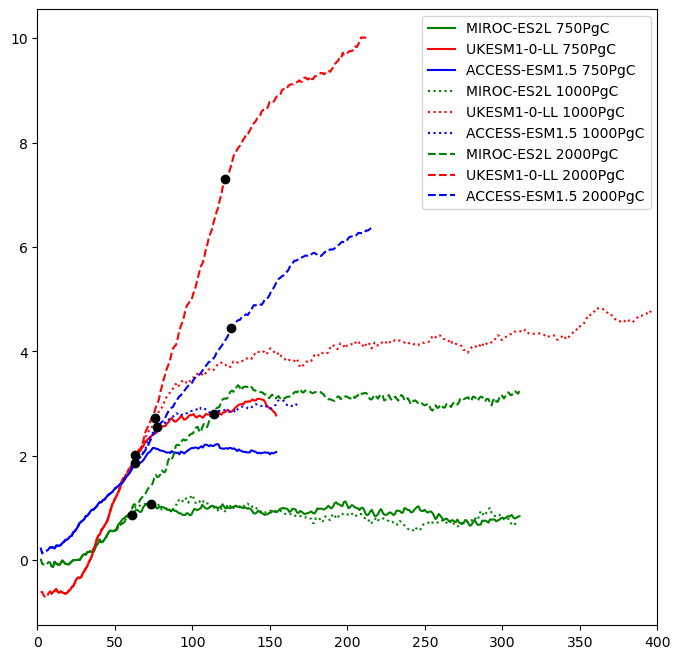

In [41]:
global_pr_anom_single_plot_rolling(concat_750PgC_full_pr,
                                            concat_1000PgC_full_pr,
                                            concat_2000PgC_full_pr,
                                                
                                            time_slice_concat_750PgC,
                                            time_slice_concat_1000PgC,
                                            time_slice_concat_2000PgC)